In [62]:
"""Implementing a movie recommendation system using the Naive Bayes
Algorithm.
@date: 24/03/2023
@author: Víctor Bocanegra

The data we're working with was obtained from:
https://grouplens.org/datasets/movielens/: ml-latest-small.zip (size: 1 MB)
https://grouplens.org/datasets/movielens/1m/: MovieLens 1M Dataset


"""

import numpy as np
import pandas as pd
from collections import defaultdict

# First attempt, very reduced dataset
data_path = "./datasets/ml-latest-small/ratings.csv" 
# Second attempt, larger dataset
data_path2 = "./datasets/ml-1m/ratings.dat"



def count_unique_ids(data_path, _dat = False):
	"""
	@param data_path: data_path (str): The path to the CSV containing the data.
	@return: tuple: A tuple containing two integers, the first one representing
		the count of unique user IDS and the second one representing the
		unique number of movieIds.
	"""

	if _dat is False:
		# Read the csv file
		data = pd.read_csv(data_path)

		# Count the unique userIds and movieIds
		unique_user_ids = data['userId'].nunique()
		unique_movie_ids = data['movieId'].nunique()


		return unique_user_ids, unique_movie_ids


def load_rating_data(data_path, n_users, n_movies):
	"""
	Load rating data from file and also return the number of ratings for each movie and movie_id index mapping.
	@param data_path: Path to the rating data file
	@param n_users: number of users
	@param n_movies: number of movies that have ratings
	@return: rating data in the numpy array of [user, movie];
			movie_n_rating, {movie_id: number of ratings};
			movie_id_mapping, {movie_id: column index in rating data}
	"""
	data = np.zeros([n_users, n_movies], dtype = np.float32)
	movie_id_mapping = {}
	movie_n_rating = defaultdict(int)
	with open(data_path, 'r') as file:
		for line in file.readlines()[1:]:
			user_id, movie_id, rating, _ = line.split(",")
			user_id = int(user_id) - 1
			if movie_id not in movie_id_mapping:
				movie_id_mapping[movie_id] = len(movie_id_mapping)
			rating = int(float(rating))
			data[user_id, movie_id_mapping[movie_id]] = rating
			if rating > 0:
				movie_n_rating[movie_id] += 1
	return data, movie_n_rating, movie_id_mapping


# Analyzing the data distribution
def display_distribution(data):
	values, counts = np.unique(data, return_counts = True)
	print("Checking value, counts: \n")
	print(values, counts)
	for value, count in zip(values, counts):
		print(f"Number of rating {int(value)}: {count}")



n_users, n_movies = count_unique_ids(data_path)
data, movie_n_rating, movie_id_mapping = load_rating_data(data_path, n_users, n_movies)

display_distribution(data)




Checking value, counts: 

[0. 1. 2. 3. 4. 5.] [5832174    4602   13101   33183   35369   13211]
Number of rating 0: 5832174
Number of rating 1: 4602
Number of rating 2: 13101
Number of rating 3: 33183
Number of rating 4: 35369
Number of rating 5: 13211


In [63]:
# We'll take the movie with the most known ratings as our target movie
movie_id_most, n_rating_most = sorted(movie_n_rating.items(), key=lambda d: d[1], reverse=True)[0]
print(f"Movie ID: {movie_id_most} has {n_rating_most} ratings.")

Movie ID: 356 has 328 ratings.


The movie 356 is the target movie and ratings of the rest of the movies are signals.

In [64]:
# Constructing the dataset accordingly
X_raw = np.delete(data, movie_id_mapping[movie_id_most], axis=1)
Y_raw = data[:, movie_id_mapping[movie_id_most]]

In [65]:
# We discard samples without a rating in movie ID 356
X = X_raw[Y_raw > 0]
Y = Y_raw[Y_raw > 0]
print("Shape of X: ", X.shape)
print("Shape of Y:", Y.shape)


Shape of X:  (328, 9723)
Shape of Y: (328,)


In [66]:
# Looking at the distribution of the target movie ratings. 
display_distribution(Y)

Checking value, counts: 

[1. 2. 3. 4. 5.] [  1  12  66 133 116]
Number of rating 1: 1
Number of rating 2: 12
Number of rating 3: 66
Number of rating 4: 133
Number of rating 5: 116


In [67]:
# We can consider movies with ratings greater than 3 as being liked (being recommended):
recommend = 3
Y[Y <= recommend] = 0
Y[Y > recommend] = 1
n_pos = (Y == 1).sum()
n_neg = (Y == 0).sum()
print(f"{n_pos} positive samples and {n_neg} negative samples. ")

249 positive samples and 79 negative samples. 


In [68]:
# Splitting the test data into training and testing set with scikit/learn
from sklearn.model_selection import train_test_split
# As a good practice, the random_state is set to a fixed state during training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)


In [69]:
# Checking the testing and training sets
print(len(Y_train), len(Y_test))

262 66


In [70]:
# We're using MultinomialNB since we have input features from 0 to 5
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha = 1.0, fit_prior=True)
clf.fit(X_train, Y_train)

MultinomialNB()

In [71]:
# Using the train model to make predictions on the testing set. 
prediction_prob = clf.predict_proba(X_test)
print(prediction_prob[0:10])

[[5.90883584e-07 9.99999409e-01]
 [3.56680973e-10 1.00000000e+00]
 [1.18217609e-14 1.00000000e+00]
 [1.71056048e-18 1.00000000e+00]
 [1.19045802e-14 1.00000000e+00]
 [5.94207942e-24 1.00000000e+00]
 [5.29839752e-85 1.00000000e+00]
 [3.01733914e-61 1.00000000e+00]
 [8.74149339e-01 1.25850661e-01]
 [1.00000000e+00 1.12506774e-29]]


In [72]:
# And we now get the prediction class
prediction = clf.predict(X_test)
print(prediction[:10])

[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]


In [73]:
# We now evaluate the model's performance with classification accuracy, checking the proportion of correct predictions
accuracy = clf.score(X_test, Y_test)
print(f"The accuracy is: {accuracy*100:.1f}%")

The accuracy is: 69.7%


# Evaluation metrics

## Confusion matrix, F1 score, Precision and Recall

1. F1 score: Includes both precision and recall. Equates to their harmonic mean. $2*((precision * recall)/(precision + recall))$
2. Precision: Positive calls that are correct $TP/(TP+FP)$
3. Recall: True positives that are correctly identified $TP/(TP + FN)$

In [74]:
# An implementation of the confusion matrix using scikit-learn
from sklearn.metrics import confusion_matrix

print(confusion_matrix(Y_test, prediction, labels=[0, 1]))

[[ 3 13]
 [ 7 43]]


In [75]:
# Obtaining the F1 score, which is the result of multiplying 2*(precision * recall)/(precision + recall)
from sklearn.metrics import precision_score, recall_score, f1_score

f1 = f1_score(Y_test, prediction, pos_label = 1)
print(f1)

0.8113207547169812


In [76]:
# Getting the precision score, which is the result of dividing TP/(TP + FP)
precision = precision_score(Y_test, prediction, pos_label = 1)
print(precision)

0.7678571428571429


In [77]:
# Now getting the recall, which is the result of calculating: TP/(TP + FN)
recall = recall_score(Y_test, prediction, pos_label = 1)
print(recall)

0.86


## Calculating all metrics as a classification report

In [78]:
from sklearn.metrics import classification_report
report = classification_report(Y_test, prediction)
print(report)

              precision    recall  f1-score   support

         0.0       0.30      0.19      0.23        16
         1.0       0.77      0.86      0.81        50

    accuracy                           0.70        66
   macro avg       0.53      0.52      0.52        66
weighted avg       0.65      0.70      0.67        66



## ROC curves
A plot of the true positive rate versus the false positive rate.

In [79]:
# Preparing the data
pos_prob = prediction_prob[:, 1]
tresholds = np.arange(0.0, 1.1, 0.05)
true_pos, false_pos = [0]*len(tresholds),[0]*len(tresholds)
for pred, y in zip(pos_prob, Y_test):
    for i, treshold in enumerate(tresholds):
        if pred >= treshold: 
            # If truth and prediction are both 1
            if y == 1:
                true_pos[i] += 1
            # If truth is 0 while prediction is 1
            else:
                false_pos[i] += 1
        else:
            break




In [80]:
# Now calculating the true and false positive rates for all treshold settings
n_pos_test = (Y_test == 1).sum()
n_neg_test = (Y_test == 0).sum()
true_pos_rate = [tp / n_pos_test for tp in true_pos]
false_pos_rate = [fp / n_neg_test for fp in false_pos]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


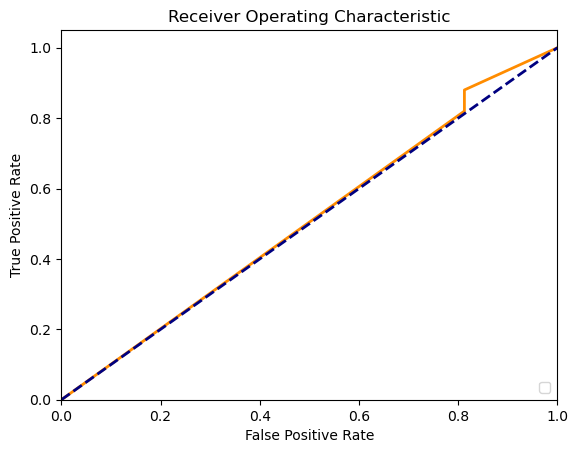

In [82]:
# Plotting the ROC curve with matplotlib
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate, color = 'darkorange', lw=lw)
plt.plot([0, 1], [0,1], color = 'navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc = 'lower right')
plt.show()

In [83]:
# Calculating the actual ROC of our model
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(Y_test, pos_prob)
print(roc_score)

0.520625


# Fine tunning with Cross Validation

In [84]:
# Using the split() method from StratifiedKfold to divide the data into chunks
from sklearn.model_selection import StratifiedKFold
k = 10 # We have very little samples, so we use a high value for kfolding
k_fold = StratifiedKFold(n_splits=k, random_state = 42, shuffle=True)

In [85]:
# Exploring with different alpha(smoothing) and fit_prior values (prior tailored to the training data)
smoothing_factor_option = [1, 2, 3, 4, 5, 6]
fit_prior_option = [True, False]
auc_record = {}


In [86]:
# Using the classifier on each of the k_folds
for train_indices, test_indices in k_fold.split(X, Y):
    X_train, X_test = X[train_indices], X[test_indices]
    Y_train, Y_test = Y[train_indices], Y[test_indices]
    for alpha in smoothing_factor_option:
        if alpha not in auc_record:
            auc_record[alpha] = {}
        for fit_prior in fit_prior_option:
            clf = MultinomialNB(alpha=alpha, fit_prior = fit_prior)
            clf.fit(X_train, Y_train)
            prediction_prob = clf.predict_proba(X_test)
            pos_prob = prediction_prob[:, 1]
            auc = roc_auc_score(Y_test, pos_prob)
            auc_record[alpha][fit_prior] = auc + auc_record[alpha].get(fit_prior, 0.0)

In [87]:
# Presenting the results
for smoothing, smoothing_record in auc_record.items():
    for fit_prior, auc in smoothing_record.items():
        print(f'    {smoothing}     {fit_prior}     {auc/k:.5f}')




    1     True     0.57980
    1     False     0.57397
    2     True     0.57483
    2     False     0.57358
    3     True     0.58523
    3     False     0.58223
    4     True     0.57980
    4     False     0.57623
    5     True     0.57455
    5     False     0.57455
    6     True     0.55955
    6     False     0.55805


In [88]:
# Retraining the model with the best set of hyperparameters (3, True, 0.58523)
clf = MultinomialNB(alpha = 3.0, fit_prior= True)
clf.fit(X_train, Y_train)
pos_prob = clf.predict_proba(X_test)[:, 1]
print("AUC with the best model: ", roc_auc_score(Y_test, pos_prob))

AUC with the best model:  0.5208333333333333
